This notebook contains the code used to plot sandpiles on the square lattice, lattice_eight and on the hexagonal lattice. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
import pylab
from numba import jit
# import plotly.plotly as py
from scipy import polyfit
from matplotlib import colors, cm
from matplotlib.collections import RegularPolyCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [66]:
geometry='lattice_four' 
# Specify the lattice used in the experiment using a string

In [67]:
if geometry=='lattice_four':
    
    @jit
    def stabilize(a):
        '''Return the stabilization of the configuration a and the count of the number of topplings required to
        reach this stable configuration
        '''
        count = 0
        size = a.shape[0]
        while np.max(a[1:(size-1), 1:(size-1)]) > 3: 
            for i in range(1,size-1):
                for j in range(1,size-1):
                    if a[i,j]> 3:
                        y = a[i,j]//4
                        a[i,j] = a[i,j]- (y*4)
                        a[i-1,j] = a[i-1,j]+ y
                        a[i,j-1] = a[i,j-1]+ y
                        a[i+1,j] = a[i+1,j]+ y
                        a[i,j+1] = a[i,j+1]+ y
                        count = count + y
            a[:,0]= 0
            a[:,size-1]= 0
            a[0,:]= 0 
            a[size-1,:]= 0
        return a, count
    
elif geometry=='lattice_eight': 
    
    @jit
    def stabilize(a):
        '''Return the stabilization of the configuration a and the count of the number of topplings required to
        reach this stable configuration
        '''
        count = 0
        size = a.shape[0]
        while np.max(a[1:(size-1), 1:(size-1)]) > 7: 
            for i in range(1,size-1):
                for j in range(1,size-1):
                    if a[i,j]> 7:
                        y = a[i,j]//8
                        a[i,j] = a[i,j]- (y*8)
                        a[i-1,j] = a[i-1,j]+ y
                        a[i,j-1] = a[i,j-1]+ y
                        a[i+1,j] = a[i+1,j]+ y
                        a[i,j+1] = a[i,j+1]+ y
                        a[i-1,j+1] = a[i-1,j+1]+ y
                        a[i+1,j+1] = a[i+1,j+1]+ y
                        a[i-1,j-1] = a[i-1,j-1]+ y
                        a[i+1,j-1] = a[i+1,j-1]+ y
                        count = count + y
            a[:,0]= 0
            a[:,size-1]= 0
            a[0,:]= 0 
            a[size-1,:]= 0
        return a, count
    
elif geometry=='hexagonal':
    
    @jit
    def stabilize(a):
        '''Return the stabilization of the configuration a and the count of the number of topplings required to
        reach this stable configuration
        '''
        count = 0
        size = a.shape[0]
        while np.max(a[1:(size-1), 1:(size-1)]) > 5: 
            for i in range(1,size-1):
                for j in range(1,size-1):
                    if a[i,j]> 5:
                        y = a[i,j]//6
                        a[i,j] = a[i,j]- (y*6)
                        a[i+1,j+1] = a[i+1,j+1]+ y
                        a[i+1,j-1] = a[i+1,j-1]+ y
                        a[i,j-2] = a[i,j-2]+ y
                        a[i-1,j-1] = a[i-1,j-1]+ y
                        a[i-1,j+1] = a[i-1,j+1]+ y
                        a[i,j+2] = a[i,j+2]+ y
                        count = count + y
            a[:,0]= 0
            a[:,size-1]= 0
            a[0,:]= 0 
            a[size-1,:]= 0
        return a, count
    
    # The function below is a modified version of the code on 
    # http://stackoverflow.com/questions/23726564/matplotlib-regularpolygon-collection-location-on-the-canvas
    @jit
    def plot_map(grid,chips,w=1000,dpi=72.):
        """
        Plot hexagon map. The hexagon color is given by the number of chips at each hexagon.

        Args:
        - grid: Grid dictionary (keys: centers, x, y );
        - chips: array contaning the number of chips for each hexagon;
        - w: width of the map in inches;
        - dpi: resolution.

        Plots the Matplotlib SubAxis instance
        """
        n_centers = grid['centers']
        x, y = grid['x'], grid['y']
        # Size of figure in inches
        xinch = (x * w / y) / dpi
        yinch = (y * w / x) / dpi
        fig = plt.figure(figsize=(xinch, yinch), dpi=dpi)
        ax = fig.add_subplot(111, aspect='equal')
        # Get pixel size between to data points
        xpoints = n_centers[:, 0]
        ypoints = n_centers[:, 1]
        ax.scatter(xpoints, ypoints, s=0.0, marker='s')
        ax.axis([min(xpoints)-1., max(xpoints)+1.,
                 min(ypoints)-1., max(ypoints)+1.])
        xy_pixels = ax.transData.transform(np.vstack([xpoints, ypoints]).T)
        xpix, ypix = xy_pixels.T

        # In matplotlib, 0,0 is the lower left corner, whereas it's usually the
        # upper right for most image software, so we'll flip the y-coords
        width, height = fig.canvas.get_width_height()
        ypix = height - ypix

        # discover radius and hexagon
        radius = .9 * (xpix[1] - xpix[0]) / np.sqrt(3)
        area_inner_circle = np.pi * (radius ** 2)
        collection_bg = RegularPolyCollection(
            numsides=6,  # a hexagon
            rotation=0,
            sizes=(area_inner_circle,),
            edgecolors = (0, 0, 0, 0),
            array= chips,
            cmap = plt.cm.BuPu,
            offsets = n_centers,
            transOffset = ax.transData,)
        ax.add_collection(collection_bg, autolim=True)

        ax.axis('off')
        ax.autoscale_view()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(collection_bg, cax=cax)
        plt.show()

    @jit
    def hexagon_grid(a):
        '''The grid formuation relies on the assumption that the sandpile a has a square matrix representation.'''
        s = 1./np.sqrt(3)
        x_dim = a.shape[0]//2 + 1
        y_dim = a.shape[1]
        
        if y_dim%2 == 1: # case the size of the square matrix is odd
            centers = np.zeros((x_dim*y_dim+y_dim//2,2))
            for j in range(y_dim):
                if j%2 == 0:
                    centers[j*x_dim+j/2:(j+1)*x_dim+j/2,0] = np.arange(x_dim)
                    centers[j*x_dim+j/2:(j+1)*x_dim+j/2,1] = j*3./2.*s
                else:
                    centers[j*x_dim+(j-1)/2:(j+1)*x_dim+(j-1)/2+1,0] = np.arange(-np.sqrt(3)/2*s,x_dim+np.sqrt(3)/2*s)
                    centers[j*x_dim+(j-1)/2:(j+1)*x_dim+(j-1)/2+1,1] = j*3./2.*s
        else: # case the size of the square matrix is even
            centers = np.zeros((x_dim*y_dim,2))
            for j in range(y_dim):
                if j%2 == 0:
                    centers[j*x_dim:(j+1)*x_dim,0] = np.arange(x_dim)
                    centers[j*x_dim:(j+1)*x_dim,1] = j*3./2.*s
                else:
                    centers[j*x_dim:(j+1)*x_dim,0] = np.arange(-np.sqrt(3)/2*s,(x_dim-1)+np.sqrt(3)/2*s)
                    centers[j*x_dim:(j+1)*x_dim,1] = j*3./2.*s

        grid = {'centers':centers, 'x': min(x_dim,y_dim),'y': max(x_dim,y_dim)}

        return grid

    def chip_values(a):
        chips = []
        n = a.shape[0]                   # here we assume a is a square matrix
        
        if n%2 == 1:                     # case n is odd
            for i in range(n):
                if i%2 == 1:                # add the left-most sink hexagon at odd indices 
                    chips.append(a[i,0])
                for j in range(i%2,n,2):    # add hexagons based on the checkboard pattern
                    chips.append(a[i,j])
                if i%2 == 1:                # add the right-most sink hexagon at odd indices 
                    chips.append(a[i,-1])
        else:                            # case n is even
            for i in range(n):
                if i%2 == 1:                # add the left-most sink hexagon at odd indices 
                    chips.append(a[i,0])
                for j in range(i%2,n,2):    # add hexagons based on the checkboard pattern
                    chips.append(a[i,j])
                if i%2 == 0:                # add the right-most sink hexagon at even indices 
                    chips.append(a[i,0])
        chips = np.asarray(chips)

        return chips

In [68]:
@jit
def initial(size, chips): 
    '''Return the stable configuration given by stabilizing the sandpile C where
    C(v) = chips  if v = (size//2, size//2)
    C(v) = 0      otherwise 
    Return the number of topplings in this avalanche
    '''
    ar = np.zeros([size, size], dtype=int)
    ar[(size//2),(size//2)] = chips
    a, count = stabilize(ar)
    
    return a, count

def plot_sandpile(a):
    '''Plot the sandpile a'''
    plt.pcolor(a, cmap=plt.cm.BuPu)
    plt.colorbar(orientation='vertical')
    plt.axis('image')
    plt.savefig('sandpile.pdf')

Use the initial function and plot the resulting configuration.

14.7859 seconds


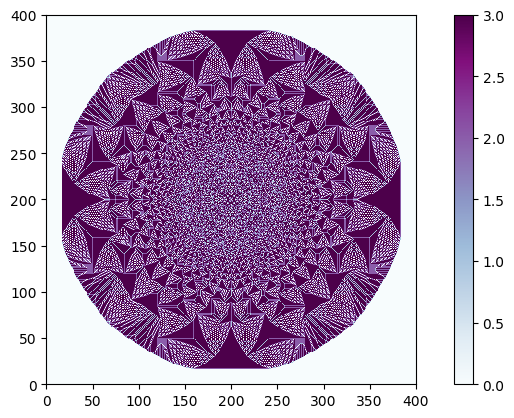

In [69]:
a, count = initial(400, 250000)

plot_sandpile(a)

Plot the sandpile on the hexagonal lattice.

In [ ]:
chips = chip_values(a)
grid = hexagon_grid(a)
plot_map(grid,chips)

The functions below are you used to study the relationship of avalanche sizes and their frequencies. 

In [ ]:
@jit
def add_chip(stableconfig, x, y):
    '''Return E_{x, y} (stableconfig)
    Return the number of topplings in this avalanche
    '''
    count = 0
    stableconfig[(x, y)] = stableconfig[(x, y)]+ 1
    stableconfig, count = stabilize(stableconfig)
    return stableconfig, count

@jit
def update(dictionary, toppling_count):
    '''Update dictionary so that the key toppling_count is incremented by one'''
    if toppling_count in dictionary: 
        dictionary[toppling_count] = dictionary[toppling_count] + 1
    else:
        dictionary.update({toppling_count:1})
    return dictionary

@jit
def final_count(stableconfg):
    '''Simulate adding a chip to each vertex of stableconfg and replace stableconfg with this new configuration.
    Return a dictionary whose keys are the avalanche size and whose values are the frequency
    '''
    dictionary = {}
    size = stableconfg.shape[0]
    for x in range(1, size-1):
        for y in range(1, size-1):
            stableconfg, count = add_chip(stableconfg, x, y)
            update(dictionary, count)
    return dictionary

@jit 
def plot_figure(d):
    '''Plot the frequency against avalanche size on a log-log plot'''
    line = plt.figure()

    x = list(d.keys())
    y = list(d.values())
    plt.loglog(x, y, "o", color= 'blue')
    return x, y

The function below models the relationship between avalanche sizes and their frequencies

In [ ]:
d = final_count(a)
d2 = {}
key = 1

# copies toppling frequency data from the original dictionary, until it finds a key that doesn’t appear 
# (=an avalanche size with frequency 0).
# then the loop stops:

while key in d:
    d2[key]=d[key]
    key = key + 1
x, y = plot_figure(d2)

xx = np.log(x[1:])
yy = np.log(y[1:])
poly = np.poly1d(np.polyfit(xx,yy,1))
plt.loglog(x[1:],np.exp(poly(xx)),linewidth=2, color= 'gray')
poly.c[0]